In [25]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
import ipdb
import re
from datasets import load_dataset
import os
import json
from collections import Counter
from random import shuffle
from scipy.stats import pearsonr, spearmanr
from minicons import scorer

tqdm.pandas()

import matplotlib.pyplot as plt
# import mplcursors
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid', context='notebook', rc={'figure.figsize':(14,10)}, font_scale=2)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('chained_assignment',None)

# Set random seeds for reproducibility on a specific machine
random.seed(1)
np.random.seed(1)
np.random.RandomState(1)
np.set_printoptions(precision=3)

ModuleNotFoundError: No module named 'minicons'

In [2]:
with open('../data/sample_coarse_personas.txt', 'r') as f:
    coarse_personas = [x.strip() for x in f.read().splitlines()]

with open('../data/sample_personas.txt', 'r') as f:
    fine_personas = [x.strip() for x in f.read().splitlines()]

dolly = pd.read_csv("../data/dolly_creative_prompts_sample.tsv", sep='\t')
questions = [x.strip() for x in dolly['instruction'].tolist()]

print(questions[23])
print(coarse_personas[21])
print(fine_personas[21])

Write something you may never forget.
an online broker
an online broker who offers trading platforms and tools for the day trader's convenience


## Load coarse and fine-grained data plus embeddings

In [3]:
coarse = pd.read_csv('../output/coarse/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
coarse = coarse.sort_values(by=['prompt_id', 'persona_id']).reset_index(drop=True)
coarse_embeddings = np.load('../output/coarse-deepseek-cutoff-persona_embeds.npy')
print(coarse.shape, coarse_embeddings.shape)

fine = pd.read_csv('../output/deepseek-cutoff-persona/DeepSeek-V3_dolly_output.tsv', sep='\t')
fine = fine.sort_values(by=['prompt_id', 'persona_id']).reset_index(drop=True)
fine_embeddings = np.load('../output/fine-deepseek-cutoff-persona_embeds.npy')
print(fine.shape, fine_embeddings.shape)

(10000, 3) (10000, 4096)
(10000, 3) (10000, 4096)


In [4]:
from sklearn.metrics.pairwise import paired_cosine_distances

In [5]:
all_dist = paired_cosine_distances(coarse_embeddings, fine_embeddings)

In [6]:
np.round(np.mean(all_dist),3), np.round(np.median(all_dist),3), np.round(np.std(all_dist),3)

(np.float32(0.211), np.float32(0.199), np.float32(0.101))

In [7]:
len_df = {'distance': [], 'prompt_id':[], 'persona_id': []}

# Load all the human responses first.
len_df['distance'] += all_dist.tolist()

for prompt_id in range(100):
    len_df['persona_id'] += [i for i in range(100)]
    len_df['prompt_id'] += [prompt_id for i in range(100)]
    
len_df=pd.DataFrame(len_df)

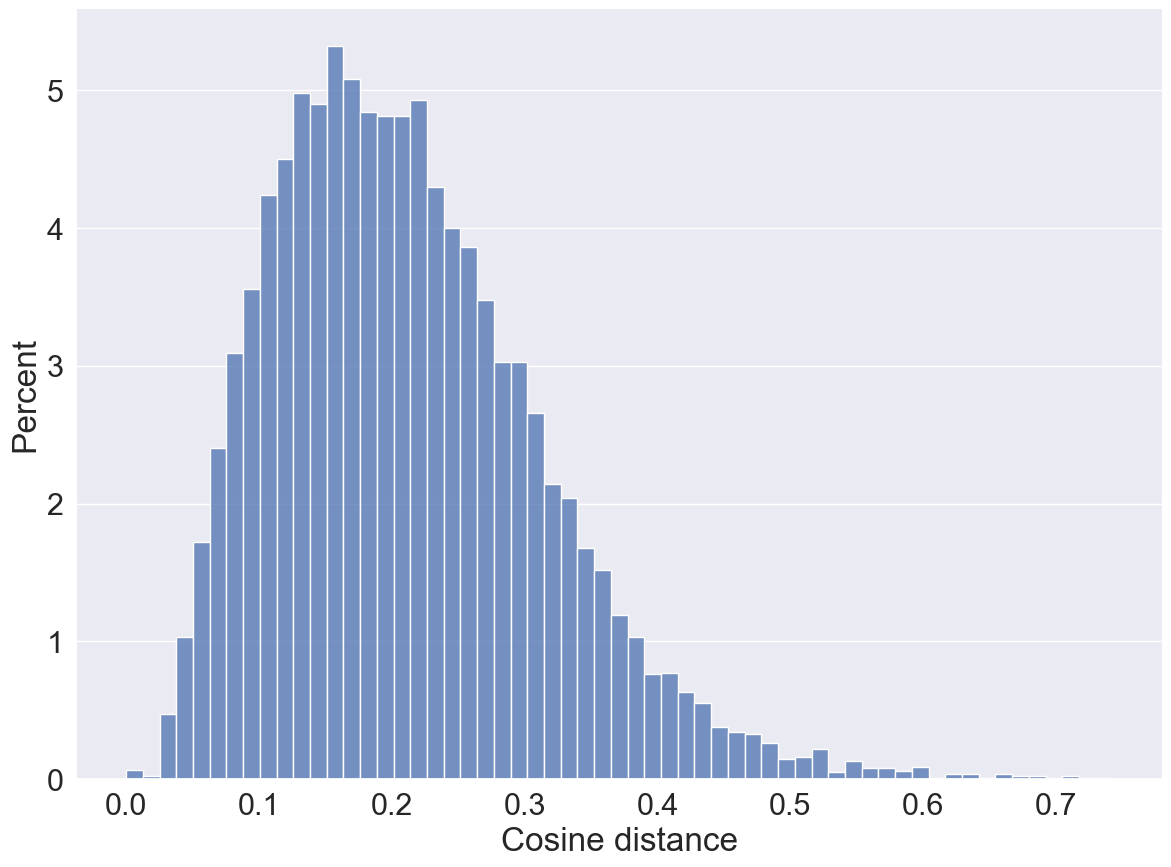

In [8]:
g = sns.histplot(len_df, x='distance', fill=True, stat='percent')
g.set_xlabel('Cosine distance')
g.set_ylabel('Percent')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
# g.set(yticklabels=[])
g.grid(axis='x')
# plt.legend([], [], frameon=False)
plt.show()

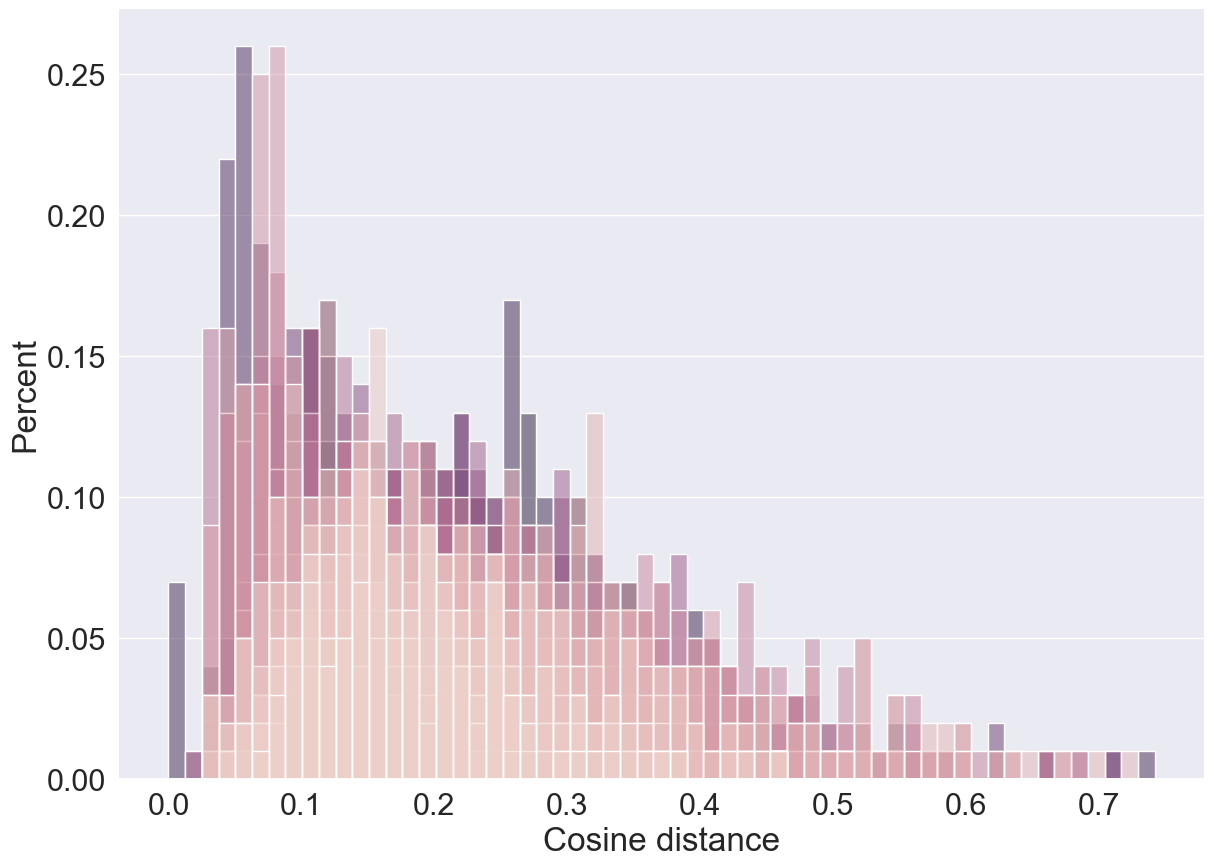

In [9]:
g = sns.histplot(len_df, x='distance', fill=True, stat='percent', hue='prompt_id')
g.set_xlabel('Cosine distance')
g.set_ylabel('Percent')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
# g.set(yticklabels=[])
g.grid(axis='x')
plt.legend([], [], frameon=False)
plt.show()

In [10]:
display(len_df.groupby('prompt_id').mean().sort_values('distance').head(5))
least_dist_prompts = len_df.groupby('prompt_id').mean().sort_values('distance').head(5).index.values
display(least_dist_prompts)

,distance,persona_id
prompt_id,,
85,0.067474,49.5
27,0.085110,49.5
20,0.086618,49.5
44,0.087037,49.5
52,0.088971,49.5


array([85, 27, 20, 44, 52])

In [11]:
for pid in least_dist_prompts:
    print(questions[pid])
    print()

Write a friendly letter to my landlord, convincing them to let me get a cat. His name is George and my name is Steve. I live alone in Unit 2C and I work long hours. Include details regarding my rental contract that currently only permits dogs under 25 pounds and caged animals and requires pet deposit and rent. Give him examples as to why those animals are not ideal (include my dog allergy) and why a cat is better. Let him know I plan a robotic vacuum and mop to keep things clean. Tell him I've already found a potential pet at the local animal shelter, who is a two-year-old shelter cat who is housebroken and friendly. Remind him that Unit 2C does not have any carpeted floors and a tiled bathroom which is good for the future litter box. Convince him I'm open to a conversation to discuss further.

Write a brief advertisement for a rentable property near a lake in the mountains. The target audience should be older adults looking for a quiet retreat.  There should be several stipulations di

In [13]:
display(len_df.groupby('prompt_id').mean().sort_values('distance').tail(5))
most_dist_prompts = len_df.groupby('prompt_id').mean().sort_values('distance').tail(5).index.values
display(most_dist_prompts)

,distance,persona_id
prompt_id,,
32,0.317340,49.5
56,0.318942,49.5
23,0.339090,49.5
11,0.344460,49.5
35,0.412558,49.5


array([32, 56, 23, 11, 35])

In [14]:
for pid in most_dist_prompts:
    print(questions[pid])
    print()

Write a diary entry about a real life incident on your recent trip with your family

Write a funny and whimsical horoscope reading

Write something you may never forget.

What is mitosis

Tell me a story



In [23]:
display(len_df.groupby('persona_id').mean().sort_values('distance').tail(5))
most_dist_personas = len_df.groupby('persona_id').mean().sort_values('distance').tail(5).index.values
display(most_dist_personas)

,distance,prompt_id
persona_id,,
10,0.276388,49.5
83,0.277924,49.5
7,0.295427,49.5
99,0.296494,49.5
16,0.317280,49.5


array([10, 83,  7, 99, 16])

In [24]:
for pid in most_dist_personas:
    print(fine_personas[pid])
    print(coarse_personas[pid])
    print()

an enthusiastic and knowledgeable store owner who encourages the input persona to reconnect with the gaming community and offers guidance on where to find Dark Sun resources
an enthusiastic and knowledgeable store owner

an academic who specializes in the fashion and clothing of specific time periods
an academic

a reporter who interviews retired soccer players to document their career and experiences
a reporter

a media mogul who is solely focused on maximizing profit through sensationalized content
a media mogul

a journalist who interviews the tribal leader to share their community's struggles and successes with a wider audience
a journalist



In [18]:
display(len_df.groupby('persona_id').mean().sort_values('distance').head(5))
least_dist_personas = len_df.groupby('persona_id').mean().sort_values('distance').head(5).index.values
display(least_dist_personas)

,distance,prompt_id
persona_id,,
47,0.153262,49.5
20,0.154729,49.5
17,0.157810,49.5
5,0.158461,49.5
50,0.159829,49.5


array([47, 20, 17,  5, 50])

In [22]:
for pid in least_dist_personas:
    print(fine_personas[pid])
    print(coarse_personas[pid])
    print()

a die-hard Iowa Hawkeye wrestling fan and former wrestler
a die-hard Iowa Hawkeye wrestling fan

a Croatian travel blogger currently living in Zagreb
a Croatian travel blogger

a knife enthusiast and collector who loves showcasing their collection on social media platforms
a knife enthusiast and collector

an Indian mother who has been traditionally attending all public functions with her family
an Indian mother

a NASA astronaut who has completed multiple spacewalks and missions to the International Space Station
a NASA astronaut



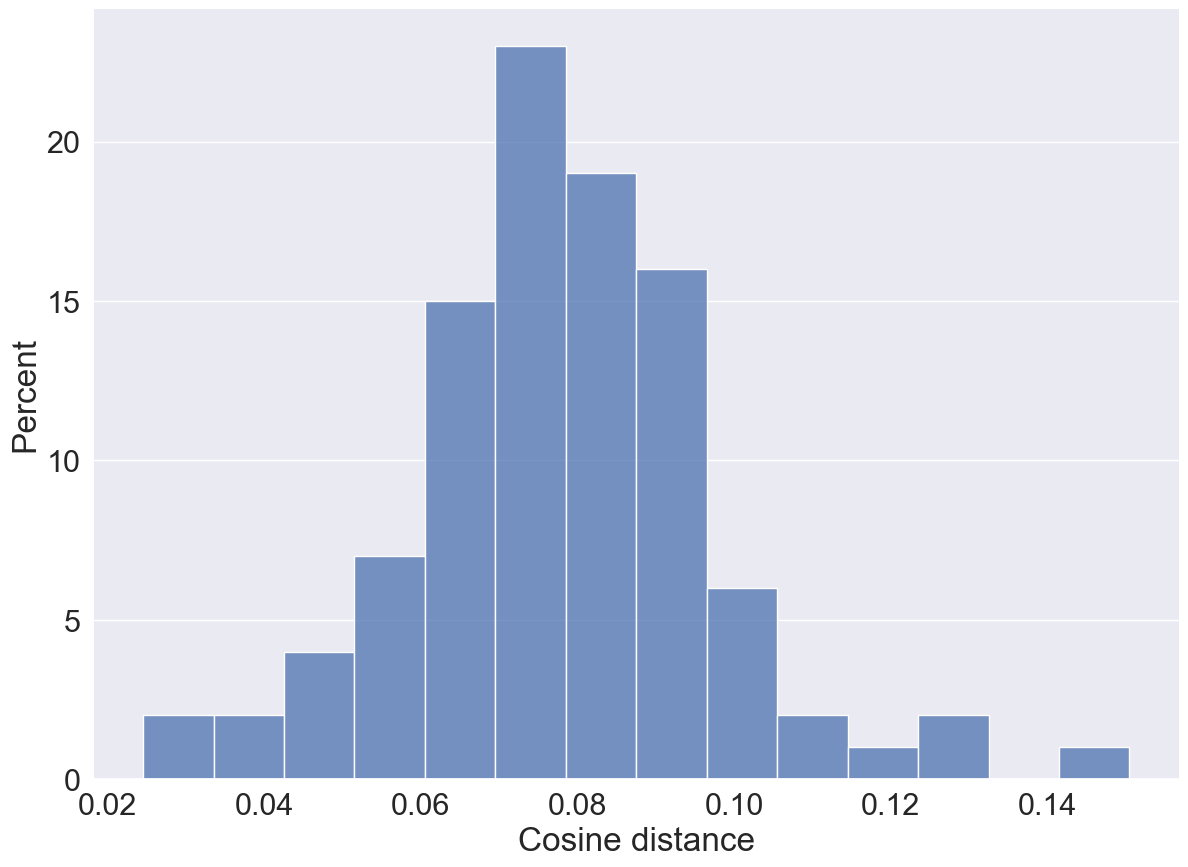

In [16]:
g = sns.histplot(len_df.groupby('prompt_id').std(), x='distance', fill=True, stat='percent')
g.set_xlabel('Cosine distance')
g.set_ylabel('Percent')
g.spines["top"].set_visible(False)
g.spines["right"].set_visible(False)
g.spines["left"].set_visible(False)
# g.set(yticklabels=[])
g.grid(axis='x')
plt.legend([], [], frameon=False)
plt.show()

## What's the correlation between prompt length and cosine distance?

In [17]:
len_df['prompt_len'] = len_df.prompt_id.apply(lambda x: len(questions[x]))

In [18]:
pearsonr(len_df.distance.values,len_df.prompt_len.values)

PearsonRResult(statistic=np.float64(-0.3170664799440983), pvalue=np.float64(2.3827594489676724e-232))

In [19]:
spearmanr(len_df.distance.values,len_df.prompt_len.values)

SignificanceResult(statistic=np.float64(-0.35837361982259736), pvalue=np.float64(8.209037937744657e-301))

In [20]:
len_df

,distance,prompt_id,persona_id,prompt_len
0,0.169041,0,0,168
1,0.175907,0,1,168
2,0.089503,0,2,168
3,0.177874,0,3,168
4,0.134144,0,4,168
...,...,...,...,...
9995,0.161001,99,95,268
9996,0.262925,99,96,268
9997,0.172591,99,97,268
9998,0.108482,99,98,268


## Finding conditional log probs of embedded clause in persona descriptions

### Aside: what's missing from coarse embeddings?

In [ ]:
prompt_counter = Counter(coarse.prompt_id.values)
{x for x in prompt_counter if prompt_counter[x]!=100}

In [ ]:
persona_counter = Counter(coarse.persona_id.values)
{x for x in persona_counter if persona_counter[x]!=100}